# Final Project: Tasten Klassifizierung anhand des Geräuchs mittels Keras und Tensorflow 
### Universität: Hochschule der Medien Stuttgart
**Fakultät für Berufsbegleitende Studiengänge**

**Studiengang:** Data Science

**Abgabedatum:**  01.03.2024

**Professor:** Dr. Christian Becker-Asano

**Student:** Raghid Allaham

## idea and approaches

## research question

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv1D,MaxPool1D, AveragePooling1D
from tensorflow.keras.optimizers import SGD, Adam
import pandas as pd
import seaborn as sns
from imutils import paths
import cv2
import os
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import wandb
from sklearn.metrics import confusion_matrix, classification_report
import librosa

In [25]:
wandb.login()

True

In [26]:
# Laden einer .wav-Datei
audio_path = './Data/lernwelt/1_2024-01-21_12-11-24.wav'
audio, sr = librosa.load(audio_path, sr=None)


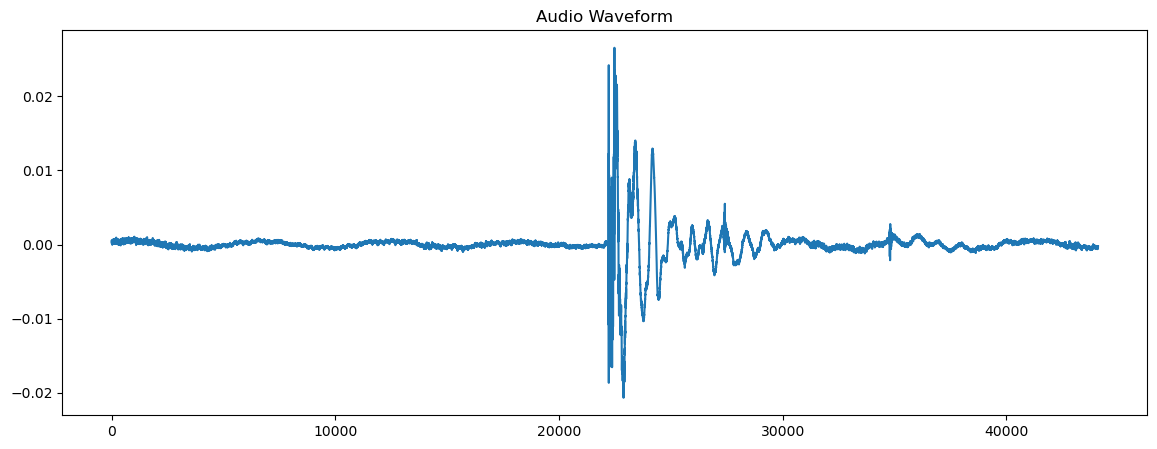

In [27]:
plt.figure(figsize=(14, 5))
plt.plot(audio)
plt.title('Audio Waveform')
plt.show()

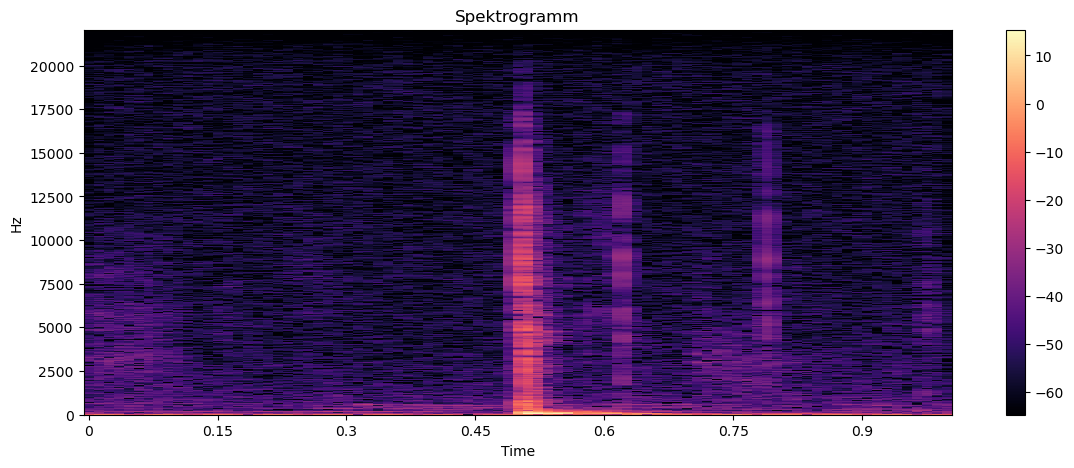

In [28]:
import librosa.display
import numpy as np

X = librosa.stft(audio)
Xdb = librosa.amplitude_to_db(abs(X))

plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title('Spektrogramm')
plt.show()


In [29]:
import os


base_path = './classes_2'  # Basispfad zu Ihren Audiodateien
classes = os.listdir(base_path)  # Liste der Klassennamen

data = []  # Liste zum Speichern der Audiodaten
labels = []  # Liste zum Speichern der zugehörigen Labels

for class_label in classes:
    class_path = os.path.join(base_path, class_label)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.endswith('.wav'):
                file_path = os.path.join(class_path, file)
                audio, sr = librosa.load(file_path, sr=None)  # Laden der Audiodatei
                audio = audio / np.max(np.abs(audio))  # Normalisierung
                data.append(audio)
                labels.append(class_label)


In [30]:
print(type(data))

<class 'list'>


In [31]:
print(f"Data matrix shape: {len(data)} x {len(data[0])}")

Data matrix shape: 1722 x 44100


In [32]:
classes

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'a',
 'b',
 'backspace',
 'ctrl',
 'd',
 'down',
 'e',
 'enter',
 'esc',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'z',
 'ß']

In [33]:
# Check if all data has the same legnth
leng_data= len(data[0])
for i in data:
    if len(i)!=leng_data:
        print(i)
    

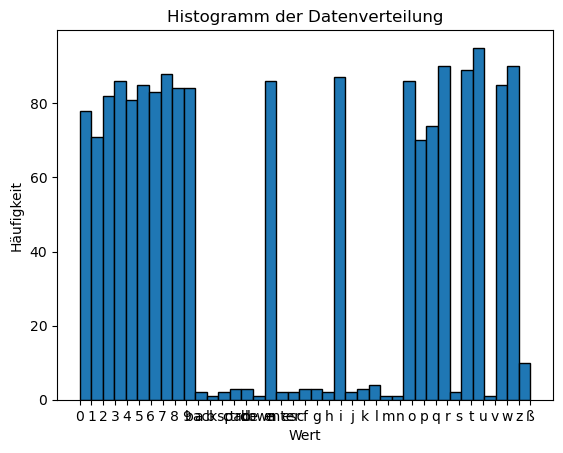

In [34]:
plt.hist(labels, edgecolor='black',bins=len(classes))
plt.title('Histogramm der Datenverteilung')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.show()

we also need to filter for the relevant classes: ['shift','space','enter','1','6']

In [35]:
relevant_classes =['0', '1', '2', '3', '4','5', '6', '7', '8', '9','q', 'r', 'e', 'i', 'o', 'p', 't', 'u', 'w', 'z']

data = []  # Liste zum Speichern der Audiodaten
labels = []  # Liste zum Speichern der zugehörigen Labels

for class_label in relevant_classes:
    class_path = os.path.join(base_path, class_label)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.endswith('.wav'):
                file_path = os.path.join(class_path, file)
                audio, sr = librosa.load(file_path, sr=None)  # Laden der Audiodatei
                audio = audio / np.max(np.abs(audio))  # Normalisierung
                data.append(audio)
                labels.append(class_label)


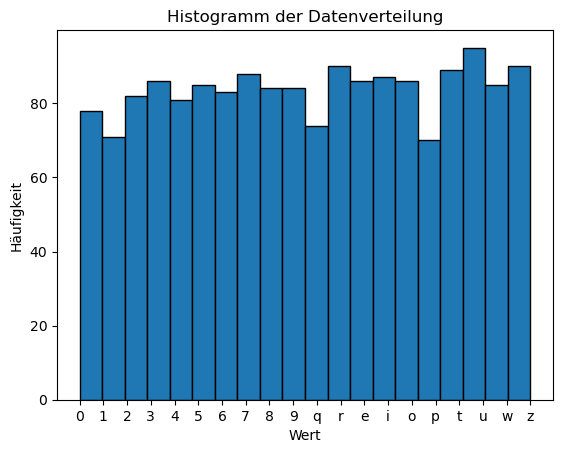

In [36]:
plt.hist(labels, edgecolor='black', bins=len(relevant_classes))
plt.title('Histogramm der Datenverteilung')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.show()

Die Basline welche geschlagen werden muss um zu beweisen, dass eine erkennung möglich ist 20 % classifcation Rate.

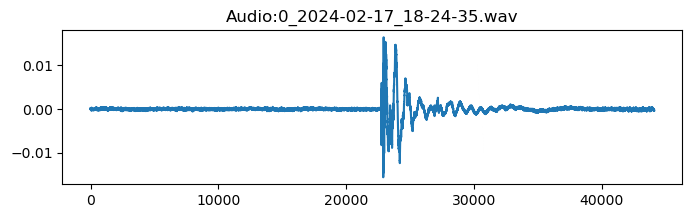

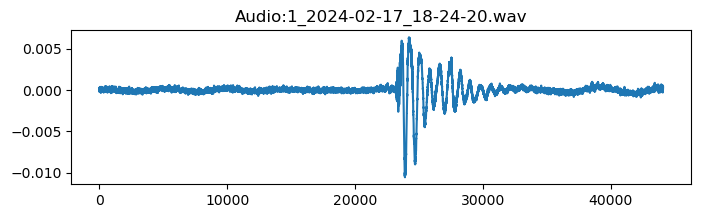

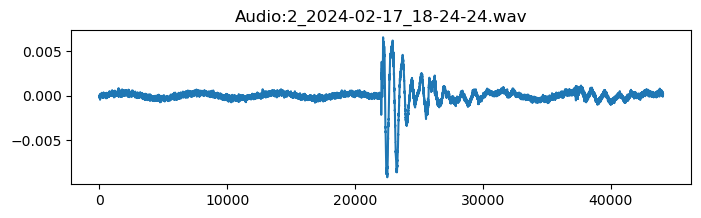

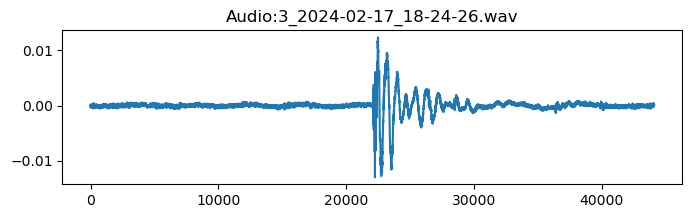

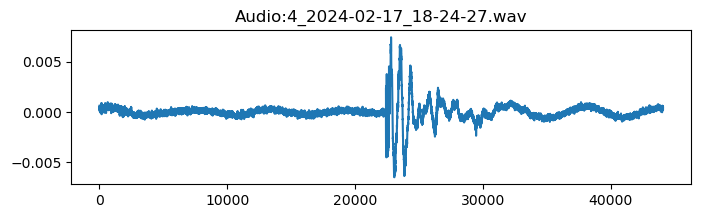

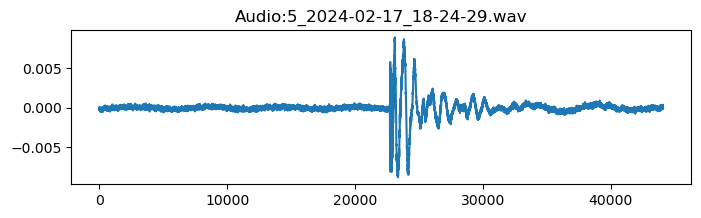

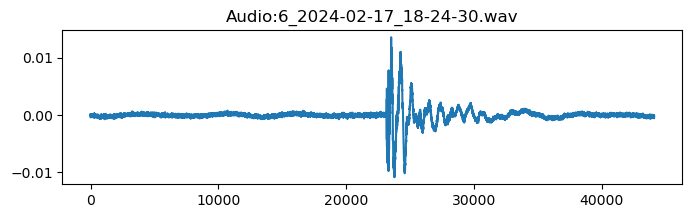

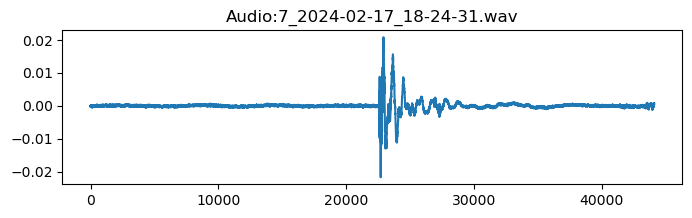

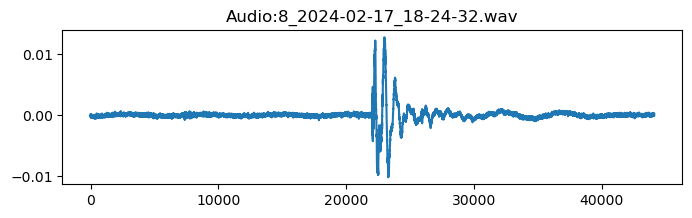

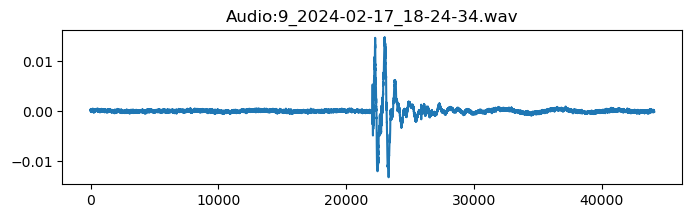

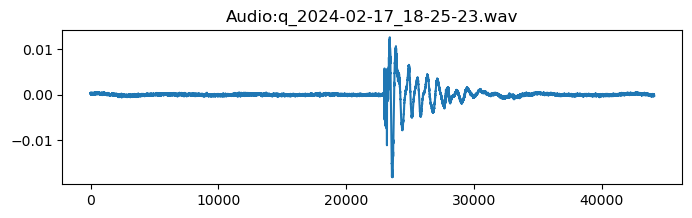

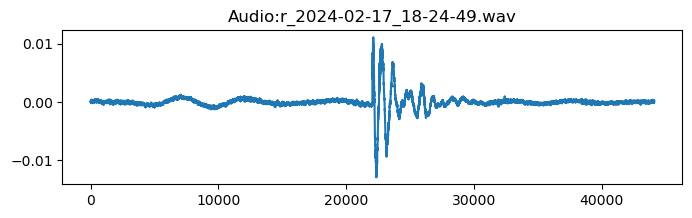

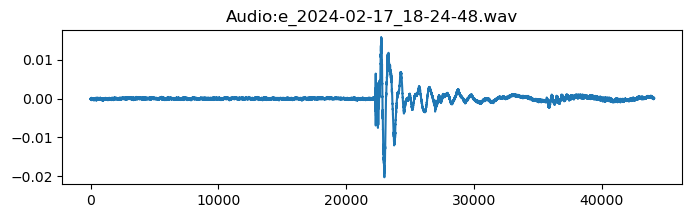

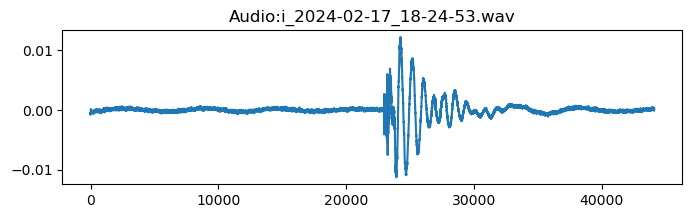

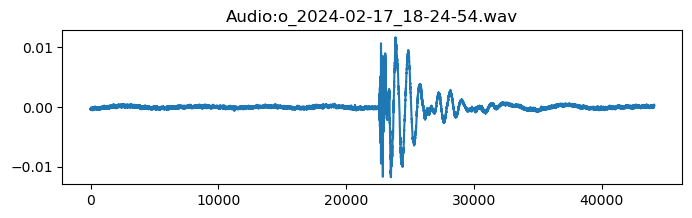

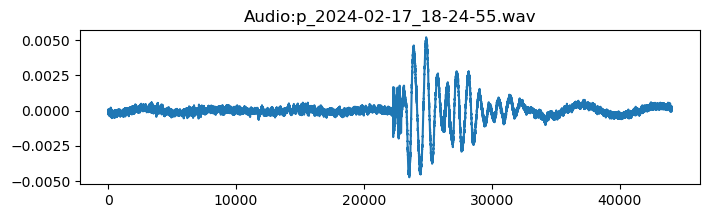

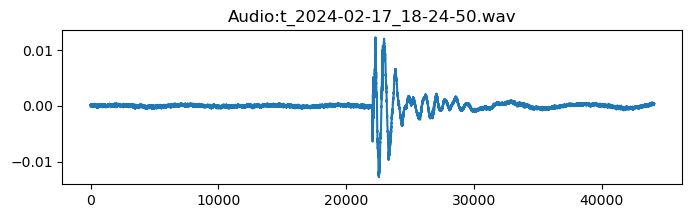

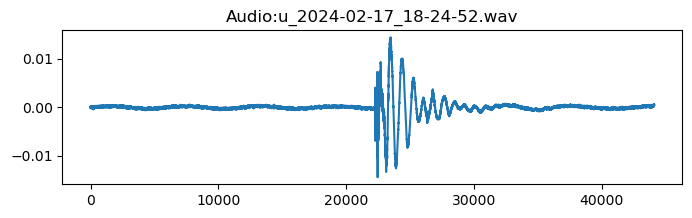

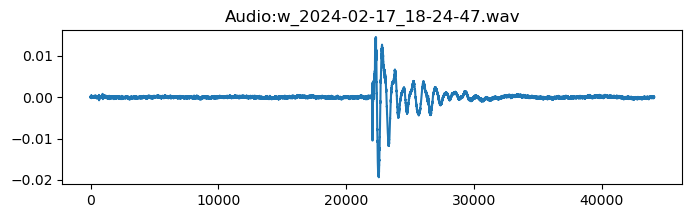

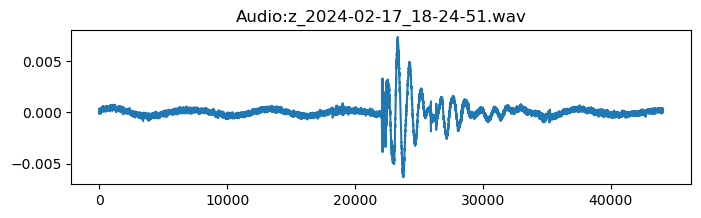

In [37]:
from sklearn.preprocessing import StandardScaler
for cli, i in enumerate(relevant_classes):
    subfolder = "./classes_2/" + i
    wav = os.listdir(subfolder)[0]
    audio, sr = librosa.load(subfolder + "/" + wav, sr=None)
    plt.figure(figsize=(8, 2))
    plt.plot(audio)
    plt.title('Audio:' + wav)
plt.show()
    


### Extract Region of interest:

From the picture above we can see that we are mostily intrested in the erea between 20000 and 30000 this why we will cut the first and last 10000 points away.

In [38]:
trimmed_data = [array[15000:-8000] for array in data]
print(len(trimmed_data),len(trimmed_data[0]) )

1674 21100


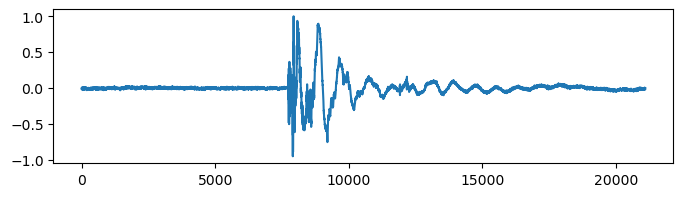

In [39]:
plt.figure(figsize=(8, 2))
plt.plot(trimmed_data[0])
plt.show()

## Data Peperation:

### Data standarization

In the previous trainings a Validation Accuracity of 65 % has been reached which is already very good. In the same time a Training Accourcty of 90 % has also been reached. Which is an indication for overfitting. To prevent overfitting, either a more samples are needed ( a bigger dataset) or we can augoment the available date with some noice pich and shifting.

Bild Hinzufügen []

In [40]:
from audiomentations import Compose, AddGaussianNoise, PitchShift, Shift



# Erstellen Sie eine Augmentations-Pipeline
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.010, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_shift=-0.1, max_shift=0.1, p=0.5),
])

augmented_samples_list = []

for sample in trimmed_data:    
    augmented_sample = augment(samples=sample, sample_rate=len(trimmed_data[0]))
    augmented_samples_list.append(augmented_sample)

In [41]:
mfccs = librosa.feature.mfcc(y=augmented_samples_list[0], sr=sr, n_mfcc=13)
len(mfccs[3])

42

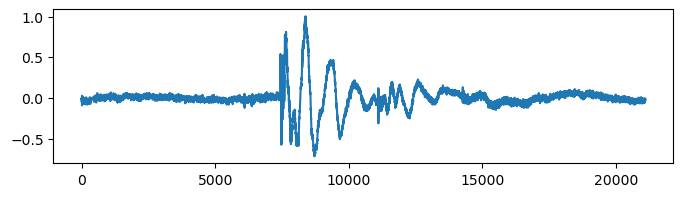

In [42]:
plt.figure(figsize=(8, 2))
plt.plot(augmented_samples_list[1])
plt.show()

In [43]:
training_data = trimmed_data + augmented_samples_list
if len(labels) != len(training_data):
    labels_train = labels + labels
len(labels)

1674

In [44]:
#training_data = augmented_samples_list
#labels_train = labels
len(labels)

1674

In [27]:
#training_data = augmented_samples_list
print(len(training_data),len(training_data[0]) )

1858 21100


In [23]:
# start a new wandb run to track this script
dense = 256 #
filter1 = 32
filter3 = 64
filter2 = 128
filter4 = 256 
kern1 = 5 # 
kern2 = 5
learning_rate = 0.005
epochs = 64 #
batch = 32
pool1 = 10
pool2 = 8
pool3 = 8
pool4 = 0
wandb.init(
    # set the wandb project where this run will be logged
    project="AAI-Final-Projekt_5",
    # track hyperparameters and run metadata
    config={
    "pool1":pool1,
    "pool2":pool2,
    "pool3":pool3,
    "pool4":pool4,
    "learning_rate": learning_rate,
    "hidden-CNN-Layer": 4,
    "dropout":4,
    "filter1":filter1,
    "filter2":filter2,
    "filter3":filter3,
    "filter4":filter4,
    "Kernel1":kern1,
    "Kernel2":kern2,
    "dropout-values:": 0.3,
    "dataset": "self_made",
    "Activation_function": "relu",
    "patience":"9",
    "epochs": epochs,
    "optimizer": "SGD",
    "loss_function": "categorical_crossentropy",
    "batch_size":batch,
    "test_size":0.3,
    "Dense":dense,
    }
)

In [45]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels_train)

In [46]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X = np.array(training_data) 
y = to_categorical(encoded_labels)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
from tensorflow.keras.layers import Conv1D, MaxPool1D

model = Sequential()
model.add(Conv1D(filters=filter1, kernel_size=kern1, input_shape=(len(trimmed_data[0]), 1), activation='relu'))
model.add(AveragePooling1D(pool_size=pool1))
model.add(Dropout(0.2))
model.add(Conv1D(filters=filter2, kernel_size=kern1, activation='relu',padding='same'))
model.add(AveragePooling1D(pool_size=pool2))
model.add(Conv1D(filters=filter3, kernel_size=kern2, activation='relu',padding='same'))
model.add(AveragePooling1D(pool_size=pool3))
model.add(Dropout(0.4))
model.add(Conv1D(filters=filter4, kernel_size=kern2, activation='relu',padding='same'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(dense, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 21096, 32)         192       
                                                                 
 average_pooling1d (Average  (None, 2109, 32)          0         
 Pooling1D)                                                      
                                                                 
 dropout (Dropout)           (None, 2109, 32)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2109, 128)         20608     
                                                                 
 average_pooling1d_1 (Avera  (None, 263, 128)          0         
 gePooling1D)                                                    
                                                                 
 conv1d_2 (Conv1D)           (None, 263, 64)           4

In [27]:
lrate = learning_rate
decay = lrate/epochs
sgd = SGD(learning_rate=lrate, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer= sgd, metrics=['accuracy'])

In [47]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=12, mode='min', restore_best_weights=True)

In [29]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch, callbacks=[early_stopping])
model.save("./Modell/audio_classifyer_light_2")

Epoch 1/64


43/43 [==============================] - 4s 73ms/step - loss: 1.6074 - accuracy: 0.2214 - val_loss: 1.6077 - val_accuracy: 0.2326
Epoch 2/64
43/43 [==============================] - 3s 61ms/step - loss: 1.6026 - accuracy: 0.2345 - val_loss: 1.6064 - val_accuracy: 0.1868
Epoch 3/64
43/43 [==============================] - 2s 57ms/step - loss: 1.5988 - accuracy: 0.2265 - val_loss: 1.6004 - val_accuracy: 0.1868
Epoch 4/64
43/43 [==============================] - 2s 57ms/step - loss: 1.5890 - accuracy: 0.2382 - val_loss: 1.5879 - val_accuracy: 0.2156
Epoch 5/64
43/43 [==============================] - 2s 55ms/step - loss: 1.5656 - accuracy: 0.3015 - val_loss: 1.5509 - val_accuracy: 0.3107
Epoch 6/64
43/43 [==============================] - 2s 55ms/step - loss: 1.5272 - accuracy: 0.3379 - val_loss: 1.5176 - val_accuracy: 0.3379
Epoch 7/64
43/43 [==============================] - 2s 58ms/step - loss: 1.4946 - accuracy: 0.3474 - val_loss: 1.4924 - val_accuracy: 0.3633
Epoch 8/64
43/43 [======

INFO:tensorflow:Assets written to: ./Modell/audio_classifyer_light_2/assets


In [30]:
for tl,vl in zip(history.history['loss'],history.history['val_loss']):
    wandb.log({"loss_train": tl, "loss_valid": vl})#

for ta,va in zip(history.history['accuracy'],history.history['val_accuracy']):
    wandb.log({"accuracy": ta, "val_accuracy": va})

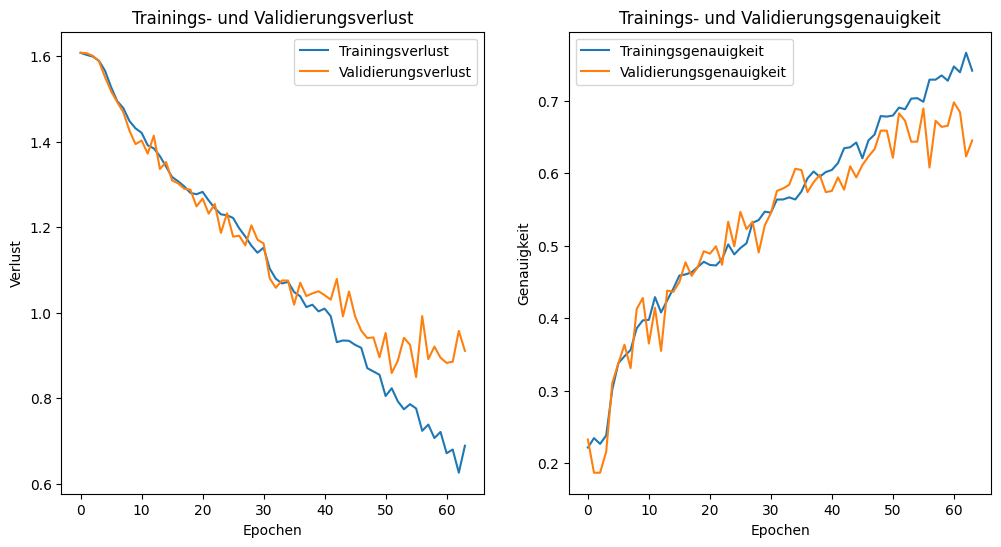

In [31]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Trainingsverlust')
plt.plot(history.history['val_loss'], label='Validierungsverlust')
plt.title('Trainings- und Validierungsverlust')
plt.xlabel('Epochen')
plt.ylabel('Verlust')
plt.legend()

# Plot für Trainings- und Validierungsgenauigkeit
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Trainingsgenauigkeit')
plt.plot(history.history['val_accuracy'], label='Validierungsgenauigkeit')
plt.title('Trainings- und Validierungsgenauigkeit')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.legend()

plt.show()

In [32]:
predictions = model.predict(X_val)

16/19 [========================>.....] - ETA: 0s

19/19 [==============================] - 0s 12ms/step


In [33]:
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_val, axis=1)

In [34]:
cm = confusion_matrix(actual_classes, predicted_classes)
cm

array([[75, 10,  3,  9, 13],
       [25, 99,  4,  3,  6],
       [ 8,  6, 75,  6,  4],
       [16,  6, 18, 69,  9],
       [12, 13,  3, 13, 84]])

In [35]:
def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(8, 6)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() 

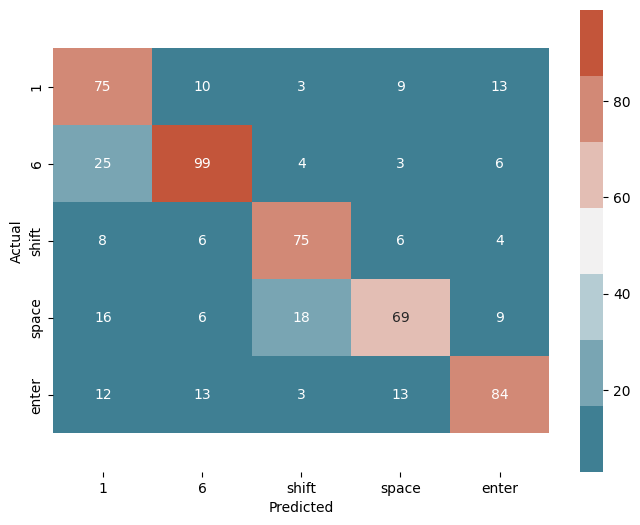

In [36]:
plot_cm(actual_classes, predicted_classes, relevant_classes)

In [37]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▁▁▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇█████
loss_train,████▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
loss_valid,███▇▇▆▆▆▆▆▅▅▅▄▅▄▄▄▄▄▃▃▂▃▃▃▃▂▂▂▂▂▁▂▂▂▂▁▁▁
val_accuracy,▂▁▁▃▃▄▄▄▃▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▆▆▇▇▇█▇█▇▇▇███▇
accuracy,0.74144
loss_train,0.68882
loss_valid,0.91063
val_accuracy,0.64516


## Second Approach

In [48]:
features_list = []
for sample in training_data:
    # MFCC-Feature-Extraktion
    mfccs = librosa.feature.mfcc(y=sample, sr=len(training_data[0]), n_mfcc=13)
    features_list.append(mfccs)

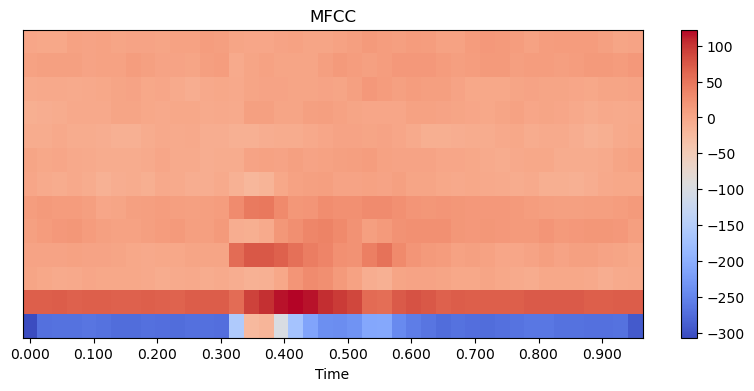

In [49]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(features_list[0], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.show()

In [50]:
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels_train)

X = np.array(features_list) 
y = to_categorical(encoded_labels)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [81]:
# start a new wandb run to track this script
dense = 256 #
filter1 = 32
filter3 = 64
filter2 = 128
filter4 = 256 
kern1 = 5 # 
kern2 = 5
kern3 = 3
learning_rate = 0.005
epochs = 100 #
batch = 32
pool1 = 10
pool2 = 8
pool3 = 8
pool4 = 0
wandb.init(
    # set the wandb project where this run will be logged
    project="AAI-Final-Projekt_5",
    # track hyperparameters and run metadata
    config={
    "model":"Frequence",
    "pool1":pool1,
    "pool2":pool2,
    "pool3":pool3,
    "pool4":pool4,
    "learning_rate": learning_rate,
    "hidden-CNN-Layer": 2,
    "dropout":4,
    "filter1":filter1,
    "filter2":filter2,
    "filter3":filter3,
    "filter4":filter4,
    "Kernel1":kern1,
    "Kernel2":kern2,
    "Kernel2":kern3,
    "dropout-values:": 0.3,
    "dataset": "self_made",
    "Activation_function": "relu",
    "patience":"9",
    "epochs": epochs,
    "optimizer": "SGD",
    "loss_function": "categorical_crossentropy",
    "batch_size":batch,
    "test_size":0.3,
    "Dense":dense,
    }
)

In [82]:
print(len(X_train),len(X_train[0][0]) )

2343 42


In [83]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D

model_2 = Sequential()
model_2.add(Conv2D(filters=filter1, kernel_size=(kern1, kern1), input_shape=(len(X_train[0]),len(X_train[0][0]), 1), activation='relu'))
#model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.2))
model_2.add(Conv2D(filters=filter2, kernel_size=(kern2, kern2), activation='relu',padding='same'))
model_2.add(AveragePooling2D(pool_size=(2, 2)))
model_2.add(Flatten())
model_2.add(Dropout(0.4))
model_2.add(Dense(dense, activation='relu'))
model_2.add(Dropout(0,2))
model_2.add(Dense(len(relevant_classes), activation='softmax'))
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 9, 38, 32)         832       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 12, 32)         0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 3, 12, 32)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 12, 128)        102528    
                                                                 
 average_pooling2d_2 (Avera  (None, 1, 6, 128)         0         
 gePooling2D)                                                    
                                                                 
 flatten_2 (Flatten)         (None, 768)              

In [84]:
lrate = learning_rate
decay = lrate/epochs
sgd = SGD(learning_rate=lrate, momentum=0.9, nesterov=False)
model_2.compile(loss='categorical_crossentropy', optimizer= sgd, metrics=['accuracy'])

In [85]:
history_2=model_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch, callbacks=[early_stopping])
model_2.save("./Modell/audio_classifyer_adam")

Epoch 1/100
74/74 [==============================] - 3s 23ms/step - loss: 3.6099 - accuracy: 0.0499 - val_loss: 2.9943 - val_accuracy: 0.0527
Epoch 2/100
74/74 [==============================] - 1s 14ms/step - loss: 2.9944 - accuracy: 0.0580 - val_loss: 2.9939 - val_accuracy: 0.0537
Epoch 3/100
74/74 [==============================] - 1s 16ms/step - loss: 2.9945 - accuracy: 0.0593 - val_loss: 2.9932 - val_accuracy: 0.0527
Epoch 4/100
74/74 [==============================] - 1s 11ms/step - loss: 2.9929 - accuracy: 0.0585 - val_loss: 2.9934 - val_accuracy: 0.0537
Epoch 5/100
74/74 [==============================] - 1s 11ms/step - loss: 2.9928 - accuracy: 0.0585 - val_loss: 2.9935 - val_accuracy: 0.0537
Epoch 6/100
74/74 [==============================] - 1s 12ms/step - loss: 2.9913 - accuracy: 0.0598 - val_loss: 2.9909 - val_accuracy: 0.0527
Epoch 7/100
74/74 [==============================] - 1s 11ms/step - loss: 2.9933 - accuracy: 0.0580 - val_loss: 2.9925 - val_accuracy: 0.0537
Epoch 

INFO:tensorflow:Assets written to: ./Modell/audio_classifyer_adam\assets


In [86]:
for tl,vl in zip(history_2.history['loss'],history_2.history['val_loss']):
    wandb.log({"loss_train": tl, "loss_valid": vl})#

for ta,va in zip(history_2.history['accuracy'],history_2.history['val_accuracy']):
    wandb.log({"accuracy": ta, "val_accuracy": va})

In [87]:
loss,acc = model_2.evaluate(X_train, y_train, verbose=0)
print("Accuracy on Test Data : %.2f%%" % (acc*100))

Accuracy on Test Data : 5.89%


In [88]:
loss,acc = model_2.evaluate(X_val, y_val, verbose=0)
print("Accuracy on Test Data : %.2f%%" % (acc*100))

Accuracy on Test Data : 5.27%


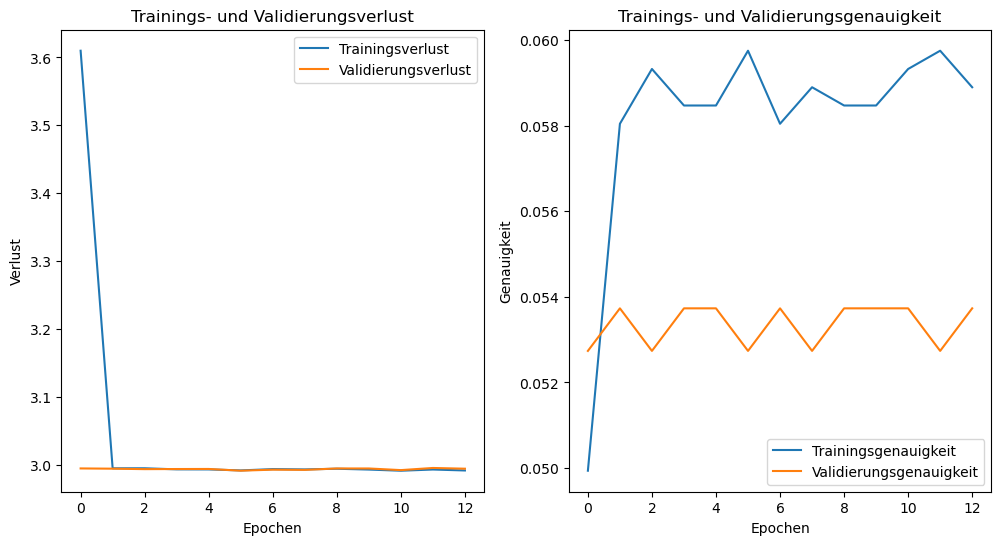

In [89]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'], label='Trainingsverlust')
plt.plot(history_2.history['val_loss'], label='Validierungsverlust')
plt.title('Trainings- und Validierungsverlust')
plt.xlabel('Epochen')
plt.ylabel('Verlust')
plt.legend()

# Plot für Trainings- und Validierungsgenauigkeit
plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'], label='Trainingsgenauigkeit')
plt.plot(history_2.history['val_accuracy'], label='Validierungsgenauigkeit')
plt.title('Trainings- und Validierungsgenauigkeit')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.legend()

plt.show()

In [90]:
predictions = model_2.predict(X_val)

32/32 [==============================] - 0s 3ms/step


In [91]:
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_val, axis=1)

In [92]:
cm = confusion_matrix(actual_classes, predicted_classes)
cm

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 49,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 35,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 56,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 54,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 42,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 55,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 50,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 45,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 52,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 57,  0,  0],
       [ 0,  0,  0,  0,  0,  0

In [93]:
def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(8, 6)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() 

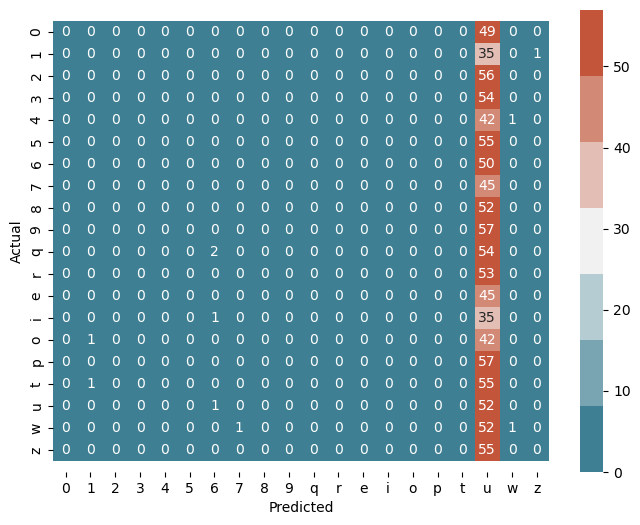

In [94]:
plot_cm(actual_classes, predicted_classes, relevant_classes)

In [95]:
wandb.finish()

accuracy,▁▇█▇▇█▇▇▇▇██▇
loss_train,█▁▁▁▁▁▁▁▁▁▁▁▁
loss_valid,▇▆▅▅▅▁▄▃▇▇▂█▆
val_accuracy,▁█▁██▁█▁███▁█
accuracy,0.0589
loss_train,2.99126
loss_valid,2.99387
val_accuracy,0.05373
